# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [107]:
# Cargar todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


## Cargar datos

In [108]:
# Carga los archivos de datos en diferentes DataFrames
df_calls = pd.read_csv('/datasets/megaline_calls.csv', header= 'infer')
df_internet = pd.read_csv('/datasets/megaline_internet.csv', header='infer')
df_messages = pd.read_csv('/datasets/megaline_messages.csv', header = 'infer')
df_plans = pd.read_csv('/datasets/megaline_plans.csv', header ='infer')
df_users = pd.read_csv('/datasets/megaline_users.csv', header = 'infer')

## Preparar los datos

### Tarifas

In [109]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
df_plans.info()
print()
print(df_plans.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes

0


In [110]:
# Imprime una muestra de los datos para las tarifas
print(df_plans.head())


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


- **Notamos que este primer DataFrame es descriptivo sobre los planes, no tiene datos ausentes y al ser solo 2 filas podemos confirmar que no tiene duplicados** 
- **Los nombres de las filas ya estan en snake_case y los datos están en el formato correcto**

#### Corregir datos

**No hay necesidad de corregir nada en este DataFrame**

#### Enriquecer los datos

**Debido a que Megaline cobra por GB, convertiremos los MB a GB para un mejor análisis, para lo cual agregarempos una columna con la información de los GB **

In [111]:
#Transformar los MB a GB
df_plans['gb_per_month_included'] = df_plans['mb_per_month_included'].astype('float')
df_plans['gb_per_month_included'] = df_plans['mb_per_month_included'] / 1000  # Considerar 1024 
print(df_plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   gb_per_month_included  
0                  15.36  
1                  30.72  


### Usuarios/as

In [112]:
# Imprime la información general/resumida sobre el DataFrame de usuarios
df_users.info()
print()
print(df_users.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

0


In [113]:
# Imprime una muestra de datos para usuarios
print(df_users.head(10))


   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                           Tulsa, OK MSA   
4     1004    Leonila   Thompson   40         Seattle-Tacoma-Bellevue, WA MSA   
5     1005      Livia    Shields   31     Dallas-Fort Worth-Arlington, TX MSA   
6     1006     Jesusa   Bradford   73  San Francisco-Oakland-Berkeley, CA MSA   
7     1007    Eusebio      Welch   42           Grand Rapids-Kentwood, MI MSA   
8     1008      Emely    Hoffman   53       Orlando-Kissimmee-Sanford, FL MSA   
9     1009      Gerry     Little   19  San Jose-Sunnyvale-Santa Clara, CA MSA   

     reg_date      plan  churn_date  
0  2018-12-24  ultimate         NaN  
1  2018-08-13      surf         

- **No contamos con filas completas duplicadas, sin embargo se hará un análisis de la columna de user_id para asegurar que no tengamos duplicados, al ser el único valor que identifica de forma única, de esta forma podemos afirmar que no hay duplicados.**
- **Tenemos valores ausentes en la columna de churn_date, se nos informa que es debido a que la tarifa se estaba usando cuando fue extraída esta base de dato, por lo que los sustituimos por una cadena vacía.**
- **Los valores están en el formato requerido, sin embargo al necesitar un análisis mensual, cambiaremos el formato de reg_date a datetime**
- **Haremos el cambio de nombre de la columna "plan" por plan_name para tener el mismo nombre en caso de necesitar la unión con el DataFrame df_plans.**


#### Corregir los datos

In [114]:
print(df_users.duplicated(subset=['user_id']).sum()) #comprobar que no hay valores ausentes en user_id

0


In [115]:
print(df_users['churn_date'].unique()) #asegurar que no hay otro valor además de fecha y NaN
df_users['churn_date'] = df_users['churn_date'].fillna('') #sustituir valores ausentes por cadenas vacías
print(df_users['churn_date'].head(15))

[nan '2018-12-18' '2018-11-16' '2018-09-07' '2018-12-30' '2018-10-07'
 '2018-12-31' '2018-11-24' '2018-11-11' '2018-12-12' '2018-11-14'
 '2018-12-27' '2018-11-29' '2018-12-22' '2018-11-30' '2018-10-13'
 '2018-07-31' '2018-12-15' '2018-12-19' '2018-10-03' '2018-10-22'
 '2018-08-16' '2018-12-26' '2018-09-01' '2018-11-21' '2018-08-19'
 '2018-12-10' '2018-09-17' '2018-11-18' '2018-09-18']
0               
1               
2               
3               
4               
5               
6     2018-12-18
7               
8               
9               
10              
11              
12    2018-11-16
13              
14              
Name: churn_date, dtype: object


#### Enriquecer los datos

**Consideramos que el cambio de tipo de dato y el cambio de nombre de la columna es un enriquecimiento, ya que no es un error del DataFrame, sin embargo es un cambio que será de utilidad más adelante**

In [116]:
#cambio de formato a datetime
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format= '%Y-%m-%d')
print(df_users['reg_date'].head(10))
print(type(df_users['reg_date']))

0   2018-12-24
1   2018-08-13
2   2018-10-21
3   2018-01-28
4   2018-05-23
5   2018-11-29
6   2018-11-27
7   2018-07-11
8   2018-08-03
9   2018-04-22
Name: reg_date, dtype: datetime64[ns]
<class 'pandas.core.series.Series'>


In [117]:
#cambio de nombre de la columna
column_new_name1= {'plan':'plan_name'}
df_users = df_users.rename(columns = column_new_name1)
print(df_users.head())

   user_id first_name  last_name  age                                   city  \
0     1000   Anamaria      Bauer   45  Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28        Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36   Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                          Tulsa, OK MSA   
4     1004    Leonila   Thompson   40        Seattle-Tacoma-Bellevue, WA MSA   

    reg_date plan_name churn_date  
0 2018-12-24  ultimate             
1 2018-08-13      surf             
2 2018-10-21      surf             
3 2018-01-28      surf             
4 2018-05-23      surf             


### Llamadas

In [118]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()
print()
print(df_calls.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

0


In [119]:
# Imprime una muestra de datos para las llamadas
print(df_calls.head(10))


         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
5  1000_388     1000  2018-12-31      2.20
6  1000_510     1000  2018-12-27      5.75
7  1000_521     1000  2018-12-28     14.18
8  1000_530     1000  2018-12-28      5.77
9  1000_544     1000  2018-12-26      4.40


- **Podemos notar que no hay filas completas duplicadas, sin embargo se hará un análisis de la columna de 'id' para asegurar que no tengamos duplicados, al ser el único valor que identifica de forma única, de esta forma podemos afirmar que no hay duplicados.**
- **Podemos confirmar que no tenemos datos ausentes en el DataFrame**
- **Haremos el cambio de nombre de la columna de 'id' por 'call_id' para uso futuro evitar la confusión de id y para mejor identificación de 'duration' a 'call_duration'**
- **Cambiaremos el formato de call_date a datetime para el análisis**
- **Redondearemos la duración de llamadas de los decimales, ya que Megaline cobra por minuto, no por segundo**
- **Podemos suponer que las llamadas de 0.0 fueron intentos de llamadas, pero no hubo respuesta**

#### Corregir los datos

In [120]:
#comprobar que no haya duplicados en id
print(df_calls.duplicated(subset=['id']).sum()) 

0


In [121]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format= '%Y-%m-%d')
print(df_calls['call_date'].head(10))
print(type(df_calls['call_date']))

0   2018-12-27
1   2018-12-27
2   2018-12-27
3   2018-12-28
4   2018-12-30
5   2018-12-31
6   2018-12-27
7   2018-12-28
8   2018-12-28
9   2018-12-26
Name: call_date, dtype: datetime64[ns]
<class 'pandas.core.series.Series'>


In [122]:
#cambio de nombre de la columna
column_new_name2= {'id':'call_id',
                  'duration': 'call_duration'}
df_calls = df_calls.rename(columns = column_new_name2)
print(df_calls.head())

    call_id  user_id  call_date  call_duration
0   1000_93     1000 2018-12-27           8.52
1  1000_145     1000 2018-12-27          13.66
2  1000_247     1000 2018-12-27          14.48
3  1000_309     1000 2018-12-28           5.76
4  1000_380     1000 2018-12-30           4.22


#### Enriquecer los datos

**Consideramos que agregar el nombre del plan será de utilidad más adelante, y agregamos la columna del redondeo**

In [123]:
df_calls = df_calls.merge(df_users, on='user_id')[['call_id','user_id','call_date','call_duration','plan_name']]
print(df_calls.head(30))

     call_id  user_id  call_date  call_duration plan_name
0    1000_93     1000 2018-12-27           8.52  ultimate
1   1000_145     1000 2018-12-27          13.66  ultimate
2   1000_247     1000 2018-12-27          14.48  ultimate
3   1000_309     1000 2018-12-28           5.76  ultimate
4   1000_380     1000 2018-12-30           4.22  ultimate
5   1000_388     1000 2018-12-31           2.20  ultimate
6   1000_510     1000 2018-12-27           5.75  ultimate
7   1000_521     1000 2018-12-28          14.18  ultimate
8   1000_530     1000 2018-12-28           5.77  ultimate
9   1000_544     1000 2018-12-26           4.40  ultimate
10  1000_693     1000 2018-12-31           4.31  ultimate
11  1000_705     1000 2018-12-31          12.78  ultimate
12  1000_735     1000 2018-12-29           1.70  ultimate
13  1000_778     1000 2018-12-28           3.29  ultimate
14  1000_826     1000 2018-12-26           9.96  ultimate
15  1000_842     1000 2018-12-27           5.85  ultimate
16    1001_0  

In [124]:
#Redondeamos los valores de la llamada hacia arriba
column1= df_calls['call_duration'] 
redondeo = np.ceil(column1)
df_calls['rounded_call_duration'] = redondeo
df_calls['rounded_call_duration'] = df_calls['rounded_call_duration'].astype('int')
print(df_calls.head(30))

     call_id  user_id  call_date  call_duration plan_name  \
0    1000_93     1000 2018-12-27           8.52  ultimate   
1   1000_145     1000 2018-12-27          13.66  ultimate   
2   1000_247     1000 2018-12-27          14.48  ultimate   
3   1000_309     1000 2018-12-28           5.76  ultimate   
4   1000_380     1000 2018-12-30           4.22  ultimate   
5   1000_388     1000 2018-12-31           2.20  ultimate   
6   1000_510     1000 2018-12-27           5.75  ultimate   
7   1000_521     1000 2018-12-28          14.18  ultimate   
8   1000_530     1000 2018-12-28           5.77  ultimate   
9   1000_544     1000 2018-12-26           4.40  ultimate   
10  1000_693     1000 2018-12-31           4.31  ultimate   
11  1000_705     1000 2018-12-31          12.78  ultimate   
12  1000_735     1000 2018-12-29           1.70  ultimate   
13  1000_778     1000 2018-12-28           3.29  ultimate   
14  1000_826     1000 2018-12-26           9.96  ultimate   
15  1000_842     1000 20

In [125]:
#comprobamos que es seguro cambiar a int la nueva columna creada con los valores redondeaos 
np.array_equal(df_calls['rounded_call_duration'], df_calls['rounded_call_duration'].astype('int'))


True

In [126]:
print(df_calls.isna().sum()) #Nos aseguramos que no tenemos ausentes después de todos los movimientos 

call_id                  0
user_id                  0
call_date                0
call_duration            0
plan_name                0
rounded_call_duration    0
dtype: int64


### Mensajes

In [127]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()
print()
print(df_messages.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB

0


In [128]:
# Imprime una muestra de datos para los mensajes
print(df_messages.head(10))


         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26
5  1000_346     1000   2018-12-29
6  1000_386     1000   2018-12-30
7  1000_413     1000   2018-12-31
8  1000_502     1000   2018-12-27
9  1000_525     1000   2018-12-28


- **Podemos notar que no hay filas completas duplicadas, sin embargo se hará un análisis de la columna de 'id' para asegurar que no tengamos duplicados, al ser el único valor que identifica de forma única, de esta forma podemos afirmar que no hay duplicados.**
- **Podemos confirmar que no tenemos datos ausentes en el DataFrame**
- **Haremos el cambio de nombre de la columna de 'id' por 'message_id' para uso futuro evitar la confusión de id**
- **Cambiaremos el formato de message_date a datetime para el análisis**

#### Corregir los datos

In [129]:
#comprobar que no haya duplicados en id
print(df_messages.duplicated(subset=['id']).sum()) 

0


In [130]:
#cambio de formato a datetime
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format= '%Y-%m-%d')
print(df_messages['message_date'].head(10))
print(type(df_messages['message_date']))

0   2018-12-27
1   2018-12-31
2   2018-12-31
3   2018-12-27
4   2018-12-26
5   2018-12-29
6   2018-12-30
7   2018-12-31
8   2018-12-27
9   2018-12-28
Name: message_date, dtype: datetime64[ns]
<class 'pandas.core.series.Series'>


In [131]:
#cambio de nombre de la columna
column_new_name3= {'id':'message_id'}
df_messages = df_messages.rename(columns = column_new_name3)
print(df_messages.head())

  message_id  user_id message_date
0   1000_125     1000   2018-12-27
1   1000_160     1000   2018-12-31
2   1000_223     1000   2018-12-31
3   1000_251     1000   2018-12-27
4   1000_255     1000   2018-12-26


#### Enriquecer los datos

**Consideramos que agregar el nombre del plan será de utilidad más adelante**

In [132]:
df_messages = df_messages.merge(df_users, on='user_id')[['message_id','user_id','message_date','plan_name']]
print(df_messages.head())

  message_id  user_id message_date plan_name
0   1000_125     1000   2018-12-27  ultimate
1   1000_160     1000   2018-12-31  ultimate
2   1000_223     1000   2018-12-31  ultimate
3   1000_251     1000   2018-12-27  ultimate
4   1000_255     1000   2018-12-26  ultimate


### Internet

In [133]:
# Imprime la información general/resumida sobre el DataFrame de internet
df_internet.info()
print()
print(df_internet.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

0


In [134]:
# Imprime una muestra de datos para el tráfico de internet
print(df_internet.head())


         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22


- **Podemos notar que no hay filas completas duplicadas, sin embargo se hará un análisis de la columna de 'id' para asegurar que no tengamos duplicados, al ser el único valor que identifica de forma única, de esta forma podemos afirmar que no hay duplicados.**
- **Podemos confirmar que no tenemos datos ausentes en el DataFrame**
- **Haremos el cambio de nombre de la columna de 'id' por 'session_id' para uso futuro evitar la confusión de id**
- **Cambiaremos el formato de 'session_date' a datetime para el análisis**
- **Cabe mencionar que los datos de internet son en mb tanto en este DataFrame como en df_plans, por lo que es necesario hacer la conversión a GB**

#### Corregir los datos

In [135]:
#comprobar que no haya duplicados en id
print(df_internet.duplicated(subset=['id']).sum())

0


In [136]:
#cambio de formato a datetime
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format= '%Y-%m-%d')
print(df_internet['session_date'].head(10))
print(type(df_internet['session_date']))

0   2018-12-29
1   2018-12-31
2   2018-12-28
3   2018-12-26
4   2018-12-27
5   2018-08-24
6   2018-12-09
7   2018-11-04
8   2018-11-27
9   2018-12-13
Name: session_date, dtype: datetime64[ns]
<class 'pandas.core.series.Series'>


In [137]:
#cambio de nombre de la columna
column_new_name4= {'id':'session_id'}
df_internet = df_internet.rename(columns = column_new_name4)
print(df_internet.head())

  session_id  user_id session_date  mb_used
0    1000_13     1000   2018-12-29    89.86
1   1000_204     1000   2018-12-31     0.00
2   1000_379     1000   2018-12-28   660.40
3   1000_413     1000   2018-12-26   270.99
4   1000_442     1000   2018-12-27   880.22


#### Enriquecer los datos

**Consideramos que agregar el nombre del plan será de utilidad más adelante**

In [138]:
df_internet = df_internet.merge(df_users, on='user_id')[['session_id','user_id','session_date','mb_used','plan_name']]
print(df_internet.head(30))

   session_id  user_id session_date  mb_used plan_name
0     1000_13     1000   2018-12-29    89.86  ultimate
1    1000_204     1000   2018-12-31     0.00  ultimate
2    1000_379     1000   2018-12-28   660.40  ultimate
3    1000_413     1000   2018-12-26   270.99  ultimate
4    1000_442     1000   2018-12-27   880.22  ultimate
5      1001_0     1001   2018-08-24   284.68      surf
6      1001_3     1001   2018-12-09   656.04      surf
7      1001_4     1001   2018-11-04    16.97      surf
8     1001_10     1001   2018-11-27   135.18      surf
9     1001_15     1001   2018-12-13   761.92      surf
10    1001_16     1001   2018-10-28   501.53      surf
11    1001_17     1001   2018-09-05   727.29      surf
12    1001_24     1001   2018-09-05   622.03      surf
13    1001_25     1001   2018-10-14   310.43      surf
14    1001_26     1001   2018-09-17     0.00      surf
15    1001_27     1001   2018-12-13   149.17      surf
16    1001_28     1001   2018-10-17     0.00      surf
17    1001

In [139]:
def redondear(mb): #Creamos una función para el redondeo de MB a GB
    if mb == 0.00:
        mb = mb
    elif mb < 1024:
        mb = 1000
    elif mb < 2048:
        mb = 2000
    return mb
our_column = df_internet['mb_used']
our_function = {'mb_used': redondear}
prueba4= our_column.agg(our_function) #aplicamos nuestra nueva función
prueba5= prueba4.reset_index() #arrojaba un error de índice, resetamos el índice
prueba5=prueba4['mb_used'] #extraemos la columna que nos interesa
df_internet['gb_used']= prueba5 #Asignamos nuestro resultado a una nueva columna
df_internet['gb_used'] = df_internet['gb_used']/ 1000
df_internet['gb_used'] = df_internet['gb_used'].astype('int')
print(df_internet.head(30))

   session_id  user_id session_date  mb_used plan_name  gb_used
0     1000_13     1000   2018-12-29    89.86  ultimate        1
1    1000_204     1000   2018-12-31     0.00  ultimate        0
2    1000_379     1000   2018-12-28   660.40  ultimate        1
3    1000_413     1000   2018-12-26   270.99  ultimate        1
4    1000_442     1000   2018-12-27   880.22  ultimate        1
5      1001_0     1001   2018-08-24   284.68      surf        1
6      1001_3     1001   2018-12-09   656.04      surf        1
7      1001_4     1001   2018-11-04    16.97      surf        1
8     1001_10     1001   2018-11-27   135.18      surf        1
9     1001_15     1001   2018-12-13   761.92      surf        1
10    1001_16     1001   2018-10-28   501.53      surf        1
11    1001_17     1001   2018-09-05   727.29      surf        1
12    1001_24     1001   2018-09-05   622.03      surf        1
13    1001_25     1001   2018-10-14   310.43      surf        1
14    1001_26     1001   2018-09-17     

In [140]:
#comprobamos que es seguro cambiar a int la nueva columna creada con los valores redondeaos 
np.array_equal(df_internet['gb_used'], df_internet['gb_used'].astype('int'))


True

In [141]:
print(df_internet.isna().sum()) #Nos aseguramos que no tenemos ausentes después de todos los movimientos 

session_id      0
user_id         0
session_date    0
mb_used         0
plan_name       0
gb_used         0
dtype: int64


## Estudiar las condiciones de las tarifas

In [142]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(df_plans)


   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   gb_per_month_included  
0                  15.36  
1                  30.72  


## Agregar datos por usuario


In [143]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
df_calls['month'] = df_calls['call_date'].dt.month
monthly_calls = df_calls.reset_index().groupby(['month'])['user_id'].value_counts()
print(monthly_calls.head(20))

month  user_id
1      1077        42
       1196        42
       1362        42
       1185        23
       1042        18
       1214         5
2      1077       111
       1362       106
       1246        84
       1196        78
       1214        63
       1185        61
       1408        53
       1138        42
       1359        39
       1042        37
       1498        37
       1171        31
       1261        14
       1155        11
Name: user_id, dtype: int64


In [144]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
monthly_minutes = df_calls.reset_index().groupby(['month','user_id'])['rounded_call_duration'].sum()
print(monthly_minutes.head(10))

month  user_id
1      1042       114
       1077       290
       1185       181
       1196       287
       1214        16
       1362       292
2      1042       254
       1077       776
       1099        39
       1138       307
Name: rounded_call_duration, dtype: int64


In [145]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
df_messages['month'] = df_messages['message_date'].dt.month
monthly_sms = df_messages.reset_index().groupby(['month'])['user_id']
monthly_sms = monthly_sms.value_counts()
print(monthly_sms.head(20))

month  user_id
1      1077       37
       1196       23
       1362       21
       1214        2
2      1077       67
       1362       58
       1408       29
       1246       26
       1196       23
       1214       15
       1028       12
       1261       11
       1155        8
       1138        7
       1099        3
3      1077       72
       1028       66
       1362       59
       1261       54
       1434       45
Name: user_id, dtype: int64


In [146]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
df_internet['month'] = df_internet['session_date'].dt.month
monthly_gb = df_internet.reset_index().groupby(['month','user_id'])['gb_used'].sum()
print(monthly_gb.head(10))

month  user_id
1      1042        7
       1077       22
       1185       21
       1196       14
       1214        4
       1362       21
2      1028       23
       1042       14
       1077       39
       1099        1
Name: gb_used, dtype: int64


In [147]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
monthly_data = pd.concat([monthly_calls,monthly_sms,monthly_minutes,monthly_gb], axis='columns').reset_index(level=['month'])
monthly_data.columns = ['month','number_of_calls','number_of_sms','rounded_call_duration','gb_used']
print(monthly_data.head(20))

         month  number_of_calls  number_of_sms  rounded_call_duration  gb_used
user_id                                                                       
1042         1             18.0            NaN                  114.0      7.0
1077         1             42.0           37.0                  290.0     22.0
1185         1             23.0            NaN                  181.0     21.0
1196         1             42.0           23.0                  287.0     14.0
1214         1              5.0            2.0                   16.0      4.0
1362         1             42.0           21.0                  292.0     21.0
1028         2              NaN           12.0                    NaN     23.0
1042         2             37.0            NaN                  254.0     14.0
1077         2            111.0           67.0                  776.0     39.0
1099         2              7.0            3.0                   39.0      1.0
1138         2             42.0            7.0      

In [148]:
# Añade la información de la tarifa
monthly_merged = monthly_data.merge(df_users, on='user_id',how='left')
monthly_with_fee = monthly_merged.merge(df_plans, on='plan_name', how='outer')
monthly_with_fee = monthly_with_fee.drop(['first_name','last_name','age','reg_date','churn_date','mb_per_month_included'],axis='columns')
print(monthly_with_fee.sort_values(by='month').head(10))

      user_id  month  number_of_calls  number_of_sms  rounded_call_duration  \
0        1042      1             18.0            NaN                  114.0   
1575     1196      1             42.0           23.0                  287.0   
1576     1214      1              5.0            2.0                   16.0   
1574     1185      1             23.0            NaN                  181.0   
1573     1077      1             42.0           37.0                  290.0   
1        1362      1             42.0           21.0                  292.0   
5        1171      2             31.0            NaN                  253.0   
4        1138      2             42.0            7.0                  307.0   
3        1099      2              7.0            3.0                   39.0   
1582     1214      2             63.0           15.0                  428.0   

      gb_used                                             city plan_name  \
0         7.0  Philadelphia-Camden-Wilmington, PA-NJ-D

In [149]:
#sustituimos los valores ausentes por 0 pero en un DataFrame nuevo, ya que en este caso significa que el usuario mando 0 mensajes, hizo 0 llamadas y utilizó 0 mb
monthly_with_fees = monthly_with_fee.fillna(0)
print(monthly_with_fees.isna().sum())

user_id                  0
month                    0
number_of_calls          0
number_of_sms            0
rounded_call_duration    0
gb_used                  0
city                     0
plan_name                0
messages_included        0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
gb_per_month_included    0
dtype: int64


In [150]:
# Calcula el ingreso mensual para cada usuario
#Restamos lo incluido menos lo consumido
monthly_with_fees['limit_minutes'] = monthly_with_fees['minutes_included'] - monthly_with_fees['rounded_call_duration']
monthly_with_fees['limit_messages'] = monthly_with_fees['messages_included'] - monthly_with_fees['number_of_sms']
monthly_with_fees['limit_gb'] = monthly_with_fees['gb_per_month_included'] - monthly_with_fees['gb_used']

#multiplicamos por el valor extra en caso de que hayan excedido su paquete
monthly_with_fees['charge_extra_min'] = monthly_with_fees['limit_minutes'] * (-monthly_with_fees['usd_per_minute'])
monthly_with_fees['charge_extra_min'] = monthly_with_fees['charge_extra_min'].where(monthly_with_fees['charge_extra_min'] > 0 ,'0')

monthly_with_fees['charge_extra_sms'] = monthly_with_fees['limit_messages'] * (-monthly_with_fees['usd_per_message'])
monthly_with_fees['charge_extra_sms'] = monthly_with_fees['charge_extra_sms'].where(monthly_with_fees['charge_extra_sms'] > 0 ,'0')

monthly_with_fees['charge_extra_gb'] = monthly_with_fees['limit_gb'] * (-monthly_with_fees['usd_per_gb'])
monthly_with_fees['charge_extra_gb'] = monthly_with_fees['charge_extra_gb'].where(monthly_with_fees['charge_extra_gb'] > 0 ,'0')

#cambiar el formato de las nuevas columnas de cargo de object a float
monthly_with_fees['charge_extra_min'] = monthly_with_fees['charge_extra_min'].astype('float')
monthly_with_fees['charge_extra_sms'] = monthly_with_fees['charge_extra_sms'].astype('float')
monthly_with_fees['charge_extra_gb'] = monthly_with_fees['charge_extra_gb'].astype('float')

print(monthly_with_fees.head())

   user_id  month  number_of_calls  number_of_sms  rounded_call_duration  \
0     1042      1             18.0            0.0                  114.0   
1     1362      1             42.0           21.0                  292.0   
2     1042      2             37.0            0.0                  254.0   
3     1099      2              7.0            3.0                   39.0   
4     1138      2             42.0            7.0                  307.0   

   gb_used                                             city plan_name  \
0      7.0  Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA      surf   
1     21.0                   Denver-Aurora-Lakewood, CO MSA      surf   
2     14.0  Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA      surf   
3      1.0        New York-Newark-Jersey City, NY-NJ-PA MSA      surf   
4     43.0         Riverside-San Bernardino-Ontario, CA MSA      surf   

   messages_included  minutes_included  ...  usd_per_gb  usd_per_message  \
0                 50        

In [151]:
#calculamos el total a pagar por usuario al mes sumando las tarifas extra de minutos, mensajes y mb
monthly_with_fees['total_charge'] = monthly_with_fees['usd_monthly_pay'] + monthly_with_fees['charge_extra_min'] + monthly_with_fees['charge_extra_sms'] + monthly_with_fees['charge_extra_gb']
print(monthly_with_fees['total_charge'])

0        20.00
1        76.40
2        20.00
3        20.00
4       296.40
         ...  
2288     70.00
2289    134.96
2290    484.96
2291    106.96
2292     70.00
Name: total_charge, Length: 2293, dtype: float64


In [152]:
monthly_with_fees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                2293 non-null   int64  
 1   month                  2293 non-null   int64  
 2   number_of_calls        2293 non-null   float64
 3   number_of_sms          2293 non-null   float64
 4   rounded_call_duration  2293 non-null   float64
 5   gb_used                2293 non-null   float64
 6   city                   2293 non-null   object 
 7   plan_name              2293 non-null   object 
 8   messages_included      2293 non-null   int64  
 9   minutes_included       2293 non-null   int64  
 10  usd_monthly_pay        2293 non-null   int64  
 11  usd_per_gb             2293 non-null   int64  
 12  usd_per_message        2293 non-null   float64
 13  usd_per_minute         2293 non-null   float64
 14  gb_per_month_included  2293 non-null   float64
 15  limi

## Estudia el comportamiento de usuario

### Llamadas

       ultimate      surf
month                    
1      6.910714  6.766667
2      6.916667  7.303279
3      6.614130  7.106742
4      7.088176  7.191899
5      7.054491  7.173700
6      7.110522  7.251863
7      7.276061  7.124836
8      7.015709  7.124718
9      7.166857  7.128537
10     7.066706  7.120604
11     7.138889  7.160421
12     7.073878  7.239358
El promedio anual del plan ultimate 7.036066746002386
El promedio anual del plan surf 7.14105201143764


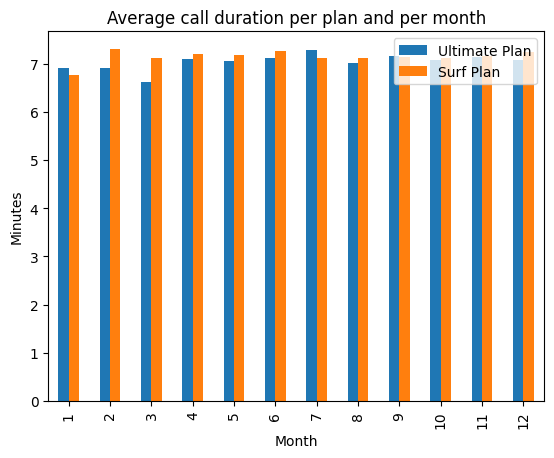

In [153]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
average_call_ultimate = df_calls.query("plan_name == 'ultimate'").groupby('month')['rounded_call_duration'].mean()

average_call_surf = df_calls.query("plan_name == 'surf'").groupby('month')['rounded_call_duration'].mean()

average_call_plan = pd.concat([average_call_ultimate, average_call_surf], axis='columns')
average_call_plan.columns = ['ultimate','surf']
print(average_call_plan)
print('El promedio anual del plan ultimate',average_call_plan['ultimate'].mean())
print('El promedio anual del plan surf',average_call_plan['surf'].mean())

average_call_plan.plot(y= ['ultimate','surf'],
                      title= 'Average call duration per plan and per month',
                      xlabel= 'Month',
                      ylabel= 'Minutes',
                      kind= 'bar')
plt.legend(['Ultimate Plan','Surf Plan'])
plt.show()

         ultimate        surf
month                        
1      193.500000  203.000000
2      403.142857  297.000000
3      304.250000  330.000000
4      336.857143  351.540000
5      406.241379  399.584416
6      370.957447  431.298969
7      427.067797  449.983471
8      421.436620  410.111111
9      437.511628  414.226804
10     450.735849  429.729958
11     445.196850  423.325088
12     459.099338  473.836478
El promedio anual del plan ultimate 387.99974229608006
El promedio anual del plan surf 384.4696912581946


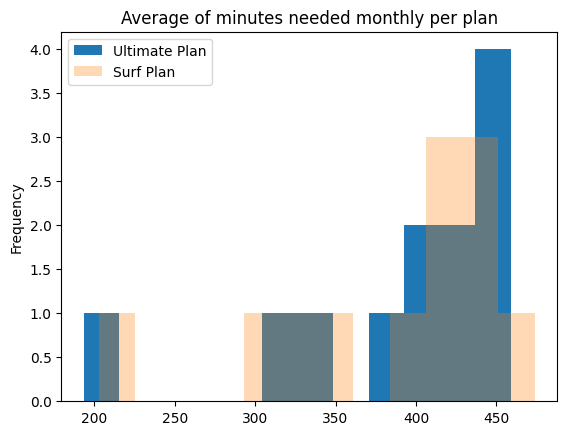

In [155]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
average_min_ultimate = monthly_with_fees.query("plan_name == 'ultimate'").groupby('month')['rounded_call_duration'].mean()

average_min_surf = monthly_with_fees.query("plan_name == 'surf'").groupby('month')['rounded_call_duration'].mean()

average_min_plan = pd.concat([average_min_ultimate, average_min_surf], axis='columns')
average_min_plan.columns = ['ultimate','surf']
print(average_min_plan)
print('El promedio anual del plan ultimate',average_min_plan['ultimate'].mean())
print('El promedio anual del plan surf',average_min_plan['surf'].mean())

average_min_ultimate.plot(kind='hist',
                      bins=12,
                      title= 'Average of minutes needed monthly per plan'
                         )

average_min_surf.plot(kind='hist',
                      bins=12,
                      alpha=0.3)

plt.legend(['Ultimate Plan','Surf Plan'])
plt.show()

In [156]:
# Calcula la media y la varianza de la duración mensual de llamadas.
print(average_call_ultimate)
var_call_ultimate = np.var(average_call_ultimate)
deviation_call_ultimate = np.sqrt(var_call_ultimate)
print('La varianza en el plan ultimate:',var_call_ultimate)
print('La desviación estándar en el plan ultimate:',deviation_call_ultimate)
print()
print(average_call_surf)
var_call_surf = np.var(average_call_surf)
deviation_call_surf = np.sqrt(var_call_surf)
print('La varianza en el plan surf:',var_call_surf)
print('La desviación estándar en el plan surf:',deviation_call_surf)

month
1     6.910714
2     6.916667
3     6.614130
4     7.088176
5     7.054491
6     7.110522
7     7.276061
8     7.015709
9     7.166857
10    7.066706
11    7.138889
12    7.073878
Name: rounded_call_duration, dtype: float64
La varianza en el plan ultimate: 0.02538808705613074
La desviación estándar en el plan ultimate: 0.1593363958928742

month
1     6.766667
2     7.303279
3     7.106742
4     7.191899
5     7.173700
6     7.251863
7     7.124836
8     7.124718
9     7.128537
10    7.120604
11    7.160421
12    7.239358
Name: rounded_call_duration, dtype: float64
La varianza en el plan surf: 0.016227769247608492
La desviación estándar en el plan surf: 0.1273882618124939


El diagrama color naranja es del plan ultimate
El diagrama color verde es del plan surf


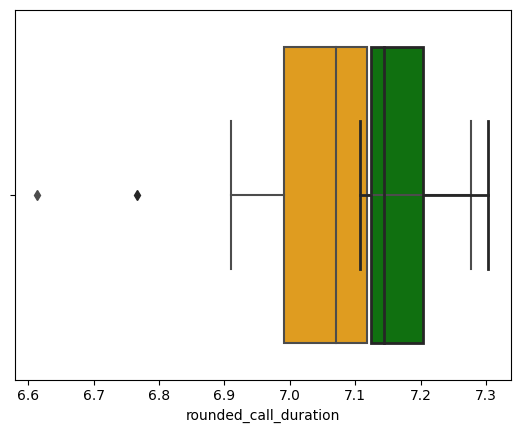

In [157]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas
sns.boxplot(x=average_call_ultimate,
            color = "orange") 

sns.boxplot(x=average_call_surf,
            color= 'green',
            linewidth = 2) 
print('El diagrama color naranja es del plan ultimate')
print('El diagrama color verde es del plan surf')

- **Podemos ver que 9 de 12 meses los usuarios del plan Surf su promedio de minutos duran más que los del plan Ultimate, sin embargo en ambos planes la duración en promedio es de 7 minutos**
- **En cuanto a la cantidad de minutos usados al mes, podemos ver que en el caso del plan Ultimate se usan más minutos, al menos 8 de 12  meses tiene un promedio por arriba de 400minutos, teniendo en cuenta que tienen incluidos 3000minutos podríamos pensar que usarían mucho más. En el caso del plan Surf al tener incluidos 500, si están más cerca de su límite.**
- **Vemos que el plan Surf está sesgado a la derecha e inluso su media es mayor que la media del plan Ultimate, basado en nuestro diagrama de caja podemos concluir que las llamadas de los usuarios del plan Surf son más largas que los del plan Ultimate**

### Mensajes

    month   ultimate       surf
0       1  15.500000  10.500000
1       2  21.571429  12.000000
2       3  20.250000  15.260870
3       4  22.047619  17.400000
4       5  32.103448  24.012987
5       6  29.340426  25.298969
6       7  32.830508  27.033058
7       8  38.478873  28.777778
8       9  37.895349  30.762887
9      10  39.443396  33.839662
10     11  38.606299  32.385159
11     12  45.006623  38.600629
El promedio de mensajes anual del plan ultimate 31.08949749446805
El promedio de mensajes anual del plan surf 24.655999855500053


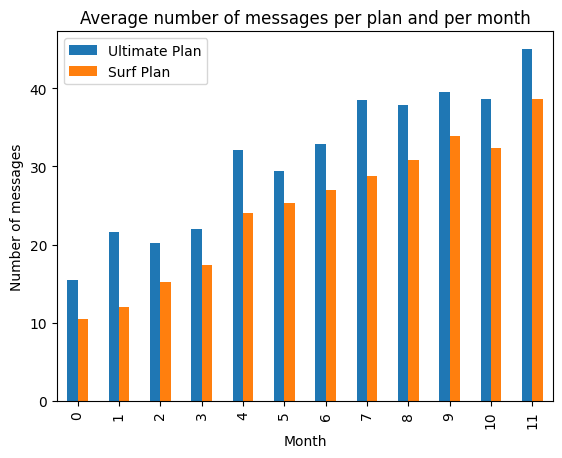

In [158]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan
average_sms_ultimate = monthly_with_fees.query("plan_name == 'ultimate'").groupby('month')['number_of_sms'].mean()

average_sms_surf = monthly_with_fees.query("plan_name == 'surf'").groupby('month')['number_of_sms'].mean()

average_sms_plan = pd.concat([average_sms_ultimate, average_sms_surf], axis='columns').reset_index()
average_sms_plan.columns = ['month','ultimate','surf']
print(average_sms_plan)
print('El promedio de mensajes anual del plan ultimate',average_sms_plan['ultimate'].mean())
print('El promedio de mensajes anual del plan surf',average_sms_plan['surf'].mean())

average_sms_plan.plot(y= ['ultimate','surf'],
                      title= 'Average number of messages per plan and per month',
                      xlabel= 'Month',
                      ylabel= 'Number of messages',
                      kind= 'bar')
plt.legend(['Ultimate Plan','Surf Plan'])
plt.show()


In [159]:
# Calcula la varianza y la desviación estándar de los mensajes que tienden a enviar cada mes
print(average_sms_ultimate)
var_sms_ultimate = np.var(average_sms_ultimate)
deviation_sms_ultimate = np.sqrt(var_sms_ultimate)
print('La varianza en el plan ultimate:',var_sms_ultimate)
print('La desviación estándar en el plan ultimate:',deviation_sms_ultimate)
print()
print(average_sms_surf)
var_sms_surf = np.var(average_sms_surf)
deviation_sms_surf = np.sqrt(var_sms_surf)
print('La varianza en el plan surf:',var_sms_surf)
print('La desviación estándar en el plan surf:',deviation_sms_surf)

month
1     15.500000
2     21.571429
3     20.250000
4     22.047619
5     32.103448
6     29.340426
7     32.830508
8     38.478873
9     37.895349
10    39.443396
11    38.606299
12    45.006623
Name: number_of_sms, dtype: float64
La varianza en el plan ultimate: 80.07446628813626
La desviación estándar en el plan ultimate: 8.948433733795891

month
1     10.500000
2     12.000000
3     15.260870
4     17.400000
5     24.012987
6     25.298969
7     27.033058
8     28.777778
9     30.762887
10    33.839662
11    32.385159
12    38.600629
Name: number_of_sms, dtype: float64
La varianza en el plan surf: 75.06477581565973
La desviación estándar en el plan surf: 8.663993064151178


El diagrama color azul es del plan ultimate
El diagrama color verde es del plan surf


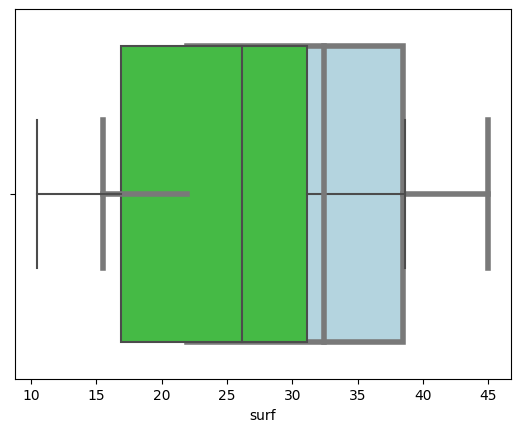

In [160]:
# Traza un diagrama de caja para visualizar la distribución del promedio de los mensajes que tienden a enviar cada mes
sns.boxplot(x= "ultimate",
            data = average_sms_plan,
            color= "lightblue",
            linewidth = 4
           )
sns.boxplot(x= "surf", 
            data = average_sms_plan,
           color = "limegreen")

print('El diagrama color azul es del plan ultimate')
print('El diagrama color verde es del plan surf')

Text(0.5, 1.0, '')

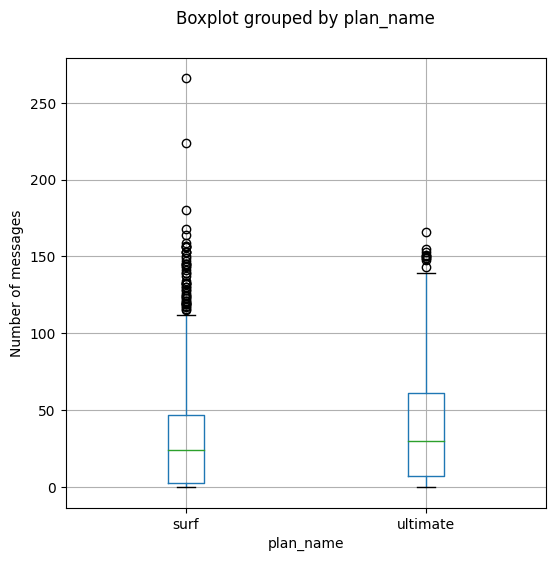

In [161]:
# Traza un diagrama de caja para visualizar la distribución de los mensajes en general
ax = monthly_with_fees.boxplot(column="number_of_sms", by="plan_name", figsize=(6,6))
ax.set_ylabel("Number of messages")
ax.set_title("")

- **Podemos observar que los usuarios del plan Ultimate enviaron más mensajes que los usuarios del plan Surf en todos los meses**
- **Teniendo en cuenta que en el plan Ultimate tienen incluidos 1000sms y el máximo promedio que enviaron fueron 45, significa que no usan demasiado este beneficio**
- **En cambio en el plan Surf tienen incluidos 50sms y su promedio máximo está por debajo de los 40 mensajes al mes, lo cual está más acorde con su uso y el beneficio que tienen**
- **De acuerdo a nuestro diagrama de caja, podemos observar que la media del plan Ultimate es mayor que la del plan Surf, y teniendo en cuenta los valores mínimos y máximos de ambos, podemos concluir que los usuarios del plan Ultimate envían más mensajes**

### Internet

    month   ultimate       surf
0       1  15.250000  14.000000
1       2  39.714286  30.000000
2       3  40.250000  31.260870
3       4  38.428571  28.880000
4       5  39.310345  33.844156
5       6  35.851064  37.515464
6       7  39.644068  40.264463
7       8  42.619718  40.277778
8       9  40.465116  40.221649
9      10  41.556604  41.987342
10     11  40.732283  39.957597
11     12  44.377483  43.949686
El promedio de GB anual del plan ultimate 38.18329490563585
El promedio de GB anual del plan surf 35.17991698991819


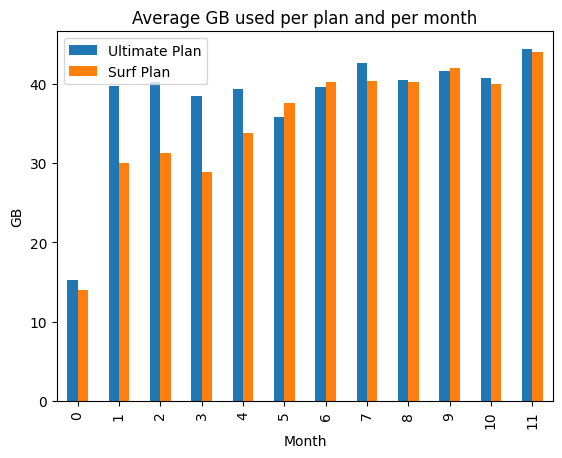

In [162]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
average_gb_ultimate = monthly_with_fees.query("plan_name == 'ultimate'").groupby('month')['gb_used'].mean()

average_gb_surf = monthly_with_fees.query("plan_name == 'surf'").groupby('month')['gb_used'].mean()

average_gb_plan = pd.concat([average_gb_ultimate, average_gb_surf], axis='columns').reset_index()
average_gb_plan.columns = ['month','ultimate','surf']
print(average_gb_plan)
print('El promedio de GB anual del plan ultimate',average_gb_plan['ultimate'].mean())
print('El promedio de GB anual del plan surf',average_gb_plan['surf'].mean())

average_gb_plan.plot(y= ['ultimate','surf'],
                      title= 'Average GB used per plan and per month',
                      xlabel= 'Month',
                      ylabel= 'GB',
                      kind= 'bar')
plt.legend(['Ultimate Plan','Surf Plan'])
plt.show()


In [163]:
# Calcula la varianza y la desviación estándar de la cantidad de tráfico de Internet consumido por usuarios por plan
print(average_gb_ultimate)
var_gb_ultimate = np.var(average_gb_ultimate)
deviation_gb_ultimate = np.sqrt(var_gb_ultimate)
print('La varianza en el plan ultimate:',var_gb_ultimate)
print('La desviación estándar en el plan ultimate:',deviation_gb_ultimate)
print()
print(average_gb_surf)
var_gb_surf = np.var(average_gb_surf)
deviation_gb_surf = np.sqrt(var_gb_surf)
print('La varianza en el plan surf:',var_gb_surf)
print('La desviación estándar en el plan surf:',deviation_gb_surf)

month
1     15.250000
2     39.714286
3     40.250000
4     38.428571
5     39.310345
6     35.851064
7     39.644068
8     42.619718
9     40.465116
10    41.556604
11    40.732283
12    44.377483
Name: gb_used, dtype: float64
La varianza en el plan ultimate: 51.882322316722735
La desviación estándar en el plan ultimate: 7.202938450155099

month
1     14.000000
2     30.000000
3     31.260870
4     28.880000
5     33.844156
6     37.515464
7     40.264463
8     40.277778
9     40.221649
10    41.987342
11    39.957597
12    43.949686
Name: gb_used, dtype: float64
La varianza en el plan surf: 63.42027546585198
La desviación estándar en el plan surf: 7.963684791969857


El diagrama color azul es del plan ultimate
El diagrama color verde es del plan surf


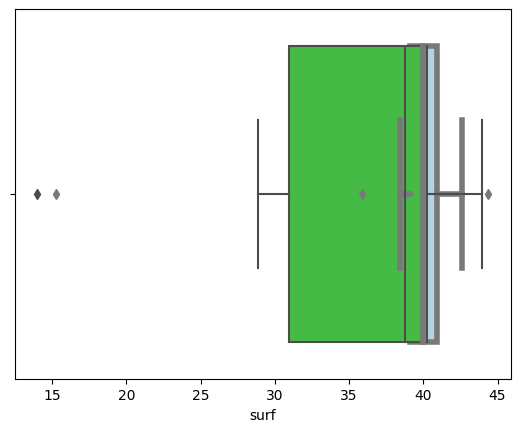

In [164]:
# Traza un diagrama de caja para visualizar la distribución del promedio de la cantidad de tráfico de Internet consumido por usuarios
sns.boxplot(x= "ultimate",
            data = average_gb_plan,
            color= "lightblue",
            linewidth = 4
           )
sns.boxplot(x= "surf", 
            data = average_gb_plan,
           color = "limegreen")

print('El diagrama color azul es del plan ultimate')
print('El diagrama color verde es del plan surf')

Text(0.5, 1.0, '')

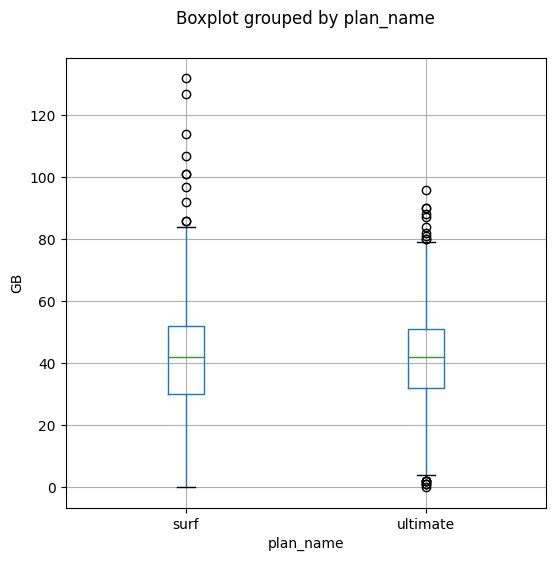

In [165]:
# Traza un diagrama de caja para visualizar la distribución de los MB usados en general
ax = monthly_with_fees.boxplot(column="gb_used", by="plan_name", figsize=(6,6))
ax.set_ylabel("GB")
ax.set_title("")

- **Podemos notar que los usuarios del plan Ultimate usaron más GB excepto en los meses de Junio, Julio y Septiembre**
- **Teniendo en cuenta que los usuarios del plan Ultimate tienen 30GB incluidos, su promedio excede los 38GB**
- **En el caso del plan Surf, tienen 15 GB incluidos, sólo en el mes de Enero no exceden, pero el resto del año exceden su paquete incluído al doble y casi al triple**
- **De acuerdo a nuestro diagrama de caja de promedio, podemos notar que tanto la media y su valor mínimo son mayores en el plan Ultimate, sin embargo el valor máximo es del plan Surf, además que tenemos muchos valores atípicos en ambos planes**
- **Al tener un diagrama general, tambíen podemos notar gracias a los valores atípicos que en el caso del Plan Surf, a pesar de tener incluidos solo 15GB, existen usuarios que exceden hasta 8 veces su límite**

## Ingreso

In [166]:
#Obtenemos el número total de usuarios por plan
total_user_ultimate = df_users.query("plan_name == 'ultimate'")['user_id'].count()
total_user_surf = df_users.query("plan_name == 'surf'")['user_id'].count()
print('El numero total de usuarios del plan ultimate',total_user_ultimate)
print('El numero total de usuarios del plan ultimate',total_user_surf)


El numero total de usuarios del plan ultimate 161
El numero total de usuarios del plan ultimate 339


    month    ultimate        surf
0       1   70.000000   48.200000
1       2  160.400000  185.330000
2       3  186.060000  204.150000
3       4  157.733333  179.318600
4       5  152.831724  223.004805
5       6  141.864681  253.235052
6       7  159.410169  282.112066
7       8  170.488451  282.341049
8       9  153.957674  277.015825
9      10  160.336981  295.488734
10     11  160.182047  276.514523
11     12  178.966358  313.495409
El promedio de cargo anual del plan ultimate 154.35261824406217
El promedio de cargo anual del plan surf 235.0171719110274


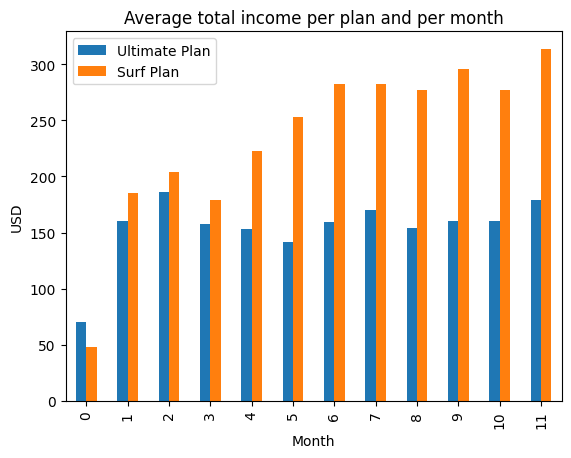

In [167]:
#Promedio de la tarifa total que pagan los usuarios al mes por plan
average_fee_ultimate = monthly_with_fees.query("plan_name == 'ultimate'").groupby('month')['total_charge'].mean()

average_fee_surf = monthly_with_fees.query("plan_name == 'surf'").groupby('month')['total_charge'].mean()

average_fee_plan = pd.concat([average_fee_ultimate, average_fee_surf], axis='columns').reset_index()
average_fee_plan.columns = ['month','ultimate','surf']
print(average_fee_plan)

print('El promedio de cargo anual del plan ultimate',average_fee_plan['ultimate'].mean())
print('El promedio de cargo anual del plan surf',average_fee_plan['surf'].mean())

average_fee_plan.plot(y= ['ultimate','surf'],
                      title= 'Average total income per plan and per month',
                      xlabel= 'Month',
                      ylabel= 'USD',
                      kind= 'bar')
plt.legend(['Ultimate Plan','Surf Plan'])
plt.show()


    month    ultimate        surf
0       1    0.000000   28.200000
1       2   90.400000  164.266667
2       3  116.060000  183.426087
3       4   87.733333  158.208000
4       5   82.831724  201.220779
5       6   71.864681  231.484536
6       7   89.410169  259.768595
7       8  100.488451  260.508642
8       9   83.957674  255.393814
9      10   90.336981  273.443038
10     11   90.182047  254.552650
11     12  108.966358  290.642767
El promedio de cargo extra por GB anual del plan ultimate 84.35261824406227
El promedio de cargo extra por GB anual del plan surf 213.42629798525203


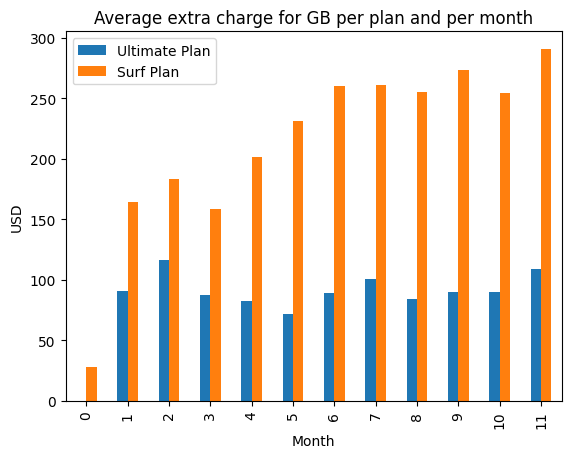

In [168]:
#Promedio de la tarifa extra por GB que pagan los usuarios al mes por plan
gb_fee_ultimate = monthly_with_fees.query("plan_name == 'ultimate'").groupby('month')['charge_extra_gb'].mean()

gb_fee_surf = monthly_with_fees.query("plan_name == 'surf'").groupby('month')['charge_extra_gb'].mean()

gb_fee_plan = pd.concat([gb_fee_ultimate, gb_fee_surf], axis='columns').reset_index()
gb_fee_plan.columns = ['month','ultimate','surf']
print(gb_fee_plan)

print('El promedio de cargo extra por GB anual del plan ultimate',gb_fee_plan['ultimate'].mean())
print('El promedio de cargo extra por GB anual del plan surf',gb_fee_plan['surf'].mean())

gb_fee_plan.plot(y= ['ultimate','surf'],
                      title= 'Average extra charge for GB per plan and per month',
                      xlabel= 'Month',
                      ylabel= 'USD',
                      kind= 'bar')
plt.legend(['Ultimate Plan','Surf Plan'])
plt.show()

    month  ultimate      surf
0       1       0.0  0.000000
1       2       0.0  1.036667
2       3       0.0  0.706957
3       4       0.0  1.058400
4       5       0.0  1.658571
5       6       0.0  1.601134
6       7       0.0  2.198182
7       8       0.0  1.652222
8       9       0.0  1.435979
9      10       0.0  1.794304
10     11       0.0  1.751131
11     12       0.0  2.533585
El promedio de cargo por minuto extra anual del plan ultimate 0.0
El promedio de cargo por minuto extra anual del plan surf 1.4522609587184439


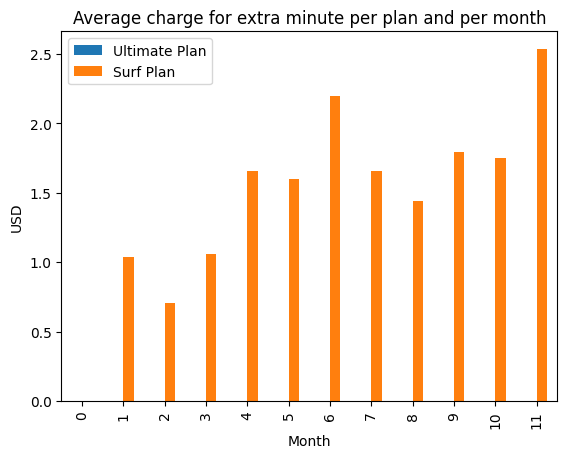

In [169]:
#Promedio de la tarifa extra por cada minuto excedente que pagan los usuarios al mes por plan
min_fee_ultimate = monthly_with_fees.query("plan_name == 'ultimate'").groupby('month')['charge_extra_min'].mean()

min_fee_surf = monthly_with_fees.query("plan_name == 'surf'").groupby('month')['charge_extra_min'].mean()

min_fee_plan = pd.concat([min_fee_ultimate, min_fee_surf], axis='columns').reset_index()
min_fee_plan.columns = ['month','ultimate','surf']
print(min_fee_plan)

print('El promedio de cargo por minuto extra anual del plan ultimate',min_fee_plan['ultimate'].mean())
print('El promedio de cargo por minuto extra anual del plan surf',min_fee_plan['surf'].mean())

min_fee_plan.plot(y= ['ultimate','surf'],
                      title= 'Average charge for extra minute per plan and per month',
                      xlabel= 'Month',
                      ylabel= 'USD',
                      kind= 'bar')
plt.legend(['Ultimate Plan','Surf Plan'])
plt.show()

    month  ultimate      surf
0       1       0.0  0.000000
1       2       0.0  0.026667
2       3       0.0  0.016957
3       4       0.0  0.052200
4       5       0.0  0.125455
5       6       0.0  0.149381
6       7       0.0  0.145289
7       8       0.0  0.180185
8       9       0.0  0.186031
9      10       0.0  0.251392
10     11       0.0  0.210742
11     12       0.0  0.319057
El promedio de cargo por mensaje extra anual del plan ultimate 0.0
El promedio de cargo por mensaje extra anual del plan surf 0.13861296705706133


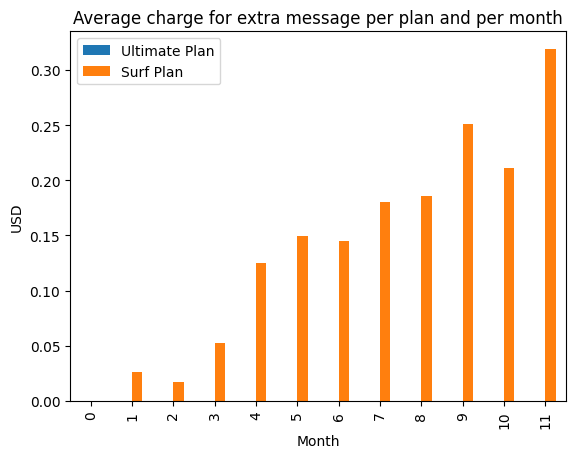

In [170]:
#Promedio de la tarifa extra por cada mensaje excedente que pagan los usuarios al mes por plan
sms_fee_ultimate = monthly_with_fees.query("plan_name == 'ultimate'").groupby('month')['charge_extra_sms'].mean()

sms_fee_surf = monthly_with_fees.query("plan_name == 'surf'").groupby('month')['charge_extra_sms'].mean()

sms_fee_plan = pd.concat([sms_fee_ultimate, sms_fee_surf], axis='columns').reset_index()
sms_fee_plan.columns = ['month','ultimate','surf']
print(sms_fee_plan)

print('El promedio de cargo por mensaje extra anual del plan ultimate',sms_fee_plan['ultimate'].mean())
print('El promedio de cargo por mensaje extra anual del plan surf',sms_fee_plan['surf'].mean())

sms_fee_plan.plot(y= ['ultimate','surf'],
                      title= 'Average charge for extra message per plan and per month',
                      xlabel= 'Month',
                      ylabel= 'USD',
                      kind= 'bar')
plt.legend(['Ultimate Plan','Surf Plan'])
plt.show()

In [171]:
# Calcula la varianza y la desviación estándar de la tarifa mensual por plan
print(average_fee_ultimate)
var_fee_ultimate = np.var(average_fee_ultimate)
deviation_fee_ultimate = np.sqrt(var_fee_ultimate)
print('La varianza en el plan ultimate:',var_fee_ultimate)
print('La desviación estándar en el plan ultimate:',deviation_fee_ultimate)
print()
print(average_fee_surf)
var_fee_surf = np.var(average_fee_surf)
deviation_fee_surf = np.sqrt(var_fee_surf)
print('La varianza en el plan surf:',var_fee_surf)
print('La desviación estándar en el plan surf:',deviation_fee_surf)

month
1      70.000000
2     160.400000
3     186.060000
4     157.733333
5     152.831724
6     141.864681
7     159.410169
8     170.488451
9     153.957674
10    160.336981
11    160.182047
12    178.966358
Name: total_charge, dtype: float64
La varianza en el plan ultimate: 774.0595770175313
La desviación estándar en el plan ultimate: 27.821926191720287

month
1      48.200000
2     185.330000
3     204.150000
4     179.318600
5     223.004805
6     253.235052
7     282.112066
8     282.341049
9     277.015825
10    295.488734
11    276.514523
12    313.495409
Name: total_charge, dtype: float64
La varianza en el plan surf: 4971.650917750647
La desviación estándar en el plan surf: 70.50993488687


El diagrama color azul es del plan ultimate
El diagrama color verde es del plan surf


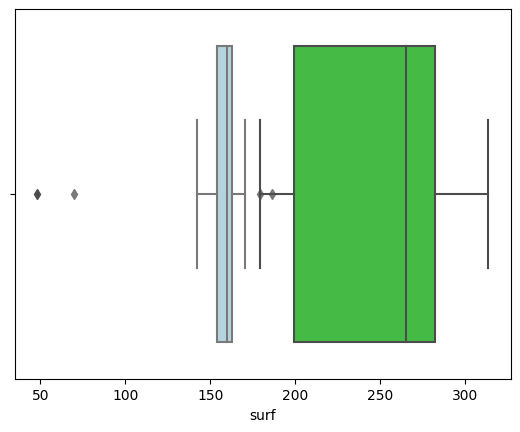

In [172]:
# Diagrama de caja para visualizar la distribución del promedio de la tarifa mensual por plan
sns.boxplot(x= "ultimate",
            data = average_fee_plan,
            color= "lightblue"
           )
sns.boxplot(x= "surf", 
            data = average_fee_plan,
           color = "limegreen")

print('El diagrama color azul es del plan ultimate')
print('El diagrama color verde es del plan surf')

- **Podemos observar en la tarifa total que pagan en promedio los usuarios al mes, que exceptuando el mes de Enero, los usuarios del plan Surf pagaron más que los usuarios del Plan Ultimate, están pagando entre 10 y 15 veces su tarifa.**
- **En el caso de los usuarios del plan Ultimate, exceptuando el mes de Enero, el resto del año en promedio están pagando el doble de su tarifa**
- **Hemos realizado 3 tablas adicionales para identificar de donde viene ese costo extra que están pagando los usuarios:**
  - **En el plan Ultimate no pagan ningun cargo extra por mensaje, o minuto, solo en el caso de GB, solo en 3 meses pagaron en promedio más de 100usd de extras**
  - **En el caso del plan Surf, el cargo extra tanto de mensajes no excede 1USD, el cargo extra de minutos máximo es de 2USD, sin embargo, el cargo extra de GB incrementa su tarifa en un 1000%**

## Prueba las hipótesis estadísticas

### Hipótesis 1 

**Nuestra hipótesis nula es:**
**El ingreso promedio de los usuarios de las tarifas Ultimate y Surf son iguales.**
**Nuestra hipótesis alternativa es:**
**El ingreso promedio de los usuarios de la tarifa Ultimate son mayores que los de la tarifa Surf.**

In [173]:
#Prueba las hipótesis
#average_fee_ultimate es el valor promedio por mes del plan ultimate 
#average_fee_surf es el valor promedio por mes del plan surf

alpha = 0.05
results = st.ttest_ind(average_fee_ultimate , average_fee_surf,equal_var = False) 

print('El promedio de cargo anual del plan ultimate',average_fee_plan['ultimate'].mean())
print('El promedio de cargo anual del plan surf',average_fee_plan['surf'].mean())
print()

print('valor p: ', results.pvalue) 

if results.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

El promedio de cargo anual del plan ultimate 154.35261824406217
El promedio de cargo anual del plan surf 235.0171719110274

valor p:  0.003224600238669817
Rechazamos la hipótesis nula


- **Existe un 0.3% que las tarifas son iguales, Podemos concluir que existe una diferencia significativa entre los importes promedio gastados.**
- **Para las variables hemos utilizado la misma variable que usamos anteriormente para comparar el gasto promedio**
- **Hemos realizado la hipótesis nula como igualdad debido al análisis anterior que muestra que el consumo es muy parecido**
- **Confirmamos que el promedio de la tarifa del Plan Ultimate es menor que el de la tarifa Surf, por lo que rechazamos la hipótesis alternativa**

### Hipótesis 2

**Nuestra hipótesis nula:**
**El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es diferente al de los usuarios de otras regiones.**

**Nuestra hipótesis alternativa:**
**El ingreso promedio de los usuarios en el área de estados Nueva York-Nueva Jersey es mayor al de los usuarios de otras regiones**

In [174]:
# Prueba las hipótesis
city_users = monthly_with_fees.groupby('city')['total_charge'].mean().reset_index()

ny_nj_cities = ['Albany-Schenectady-Troy, NY MSA',
                'Buffalo-Cheektowaga, NY MSA',
                'New York-Newark-Jersey City, NY-NJ-PA MSA',
                'Rochester, NY MSA']
ny_nj_users = city_users[city_users['city'].isin(ny_nj_cities)]
other_city_users = city_users[~city_users['city'].isin(ny_nj_cities)]
print('El promedio de tarifa de los usuarios del área de NY-NJ es:',ny_nj_users['total_charge'].mean())
print('El promedio de tarifa de los usuarios fuera del área de NY-NJ es:',other_city_users['total_charge'].mean())

alpha = 0.05
results = st.ttest_ind(ny_nj_users['total_charge'] , other_city_users['total_charge']) 

print('valor p: ', results.pvalue/2) 

if results.pvalue/2 < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")



El promedio de tarifa de los usuarios del área de NY-NJ es: 285.43783878573555
El promedio de tarifa de los usuarios fuera del área de NY-NJ es: 237.99166765385814
valor p:  0.09821524648892133
No podemos rechazar la hipótesis nula


- **Existe un 19.6% que las tarifas son diferentes, a pesar que es una probabilidad alta, podemos confirmar que en efecto son diferentes.**
- **Sin embargo, tenemos un 9.8% que las tarifas de NY-NJ son mayores, y viendo el promedio podemos confirmar que en esta área los usuarios pagan más.**

## Conclusión general


- **Pudimos observar que los usuarios del plan Surf hablan por teléfono que los usuarios del Plan Ultimate, teniendo una duración de llamada muy similar durante todo el año**
    - **Los usuarios del plan Surf en promedio usan el  76.8% de sus minutos incluidos, comparando con los usuarios del plan Ultimate que usan aproximadamente sólo el 13%**
- **Pudimos observar que los usuarios del plan Ultimate envían más mensajes de texto que los usuarios del Plan Surf**
    - **Los usuarios del plan Surf usan el 48% de sus mensajes incluidos, sin embargo los usuarios del plan Ultimate están usando menos del 5% de sus mensajes incluidos**
- **Para el uso de internet es donde podemos hacer una observación con mayor impacto, ya que los usuarios del plan Surf están usando en promedio el 233.16%, pudimos notar que pagan en promedio un cargo extra por exceso de GB del 1085%**
    - **Los usuarios del plan Ultimate hacen un uso promedio del 126%% de sus GB incluidos**
- **Esta muestra representa un 32.2% de usuarios del plan Ultimate y el 67.8% del plan Surf**

- **Teniendo en cuenta lo anterior:**
    - **Consideramos que se debe invertir más en la publicidad del plan Surf ya que la tarifa promedio de los usuarios del plan Surf es más alta que del plan Ultimate, los usuarios del plan Surf hacen mayor uso de sus beneficios y con el uso de los extra GB generan un ingreso que excede al del Plan Ultimate por un 66%, ademas que al representar un 67.8% del total de usuarios su ingreso tiene mayor impacto**
    - **Enviar publicidad del plan Ultimate específicamente a los usuarios del plan surf que pagan cargos extra**